## Phase 3: Residential Property Transaction Dataset
### INPUTS
Geocoded individual transaction data
-	Csv file(s) containing dwellings that were sold at least once between 1990 and 2020 in the Auckland Region
-	Each dwelling is identified by its unique QPID. 
-	Approx. 383,000 unique dwellings (QPIDs) in QPIDs_Auckland_1990_2020.csv

GIS shapefiles 
-	same as under phase 1

### OUTPUTS
-	csv file of dwellings (identified by QPIDs) amended with additional data points.
-	The same data listed through points 1-9 above under Phase 1 are to be added to each transaction. 
o	NOTE: For the QPIDs, the longitude and latitude given in the dataset can be used for the geo-coordinate of the observation. (i.e.: there is no need use the address to match to LINZ parcels). This is because the reported longitudes-latitude coordinates are more accurate than in the consent file, and appear to be either the centroid of the parcel or the centroid of the building.
o	Note that the geo-coordinates in the dataset are WGS1984 projection. The format of many of the shapefiles is EPSG 2193.
-	Naming convention: Use the same labels as given under Phase 1 (in red).

Note that all longitudes and latitudes should be in WGS1984 format

1.	LINZ parcel information (information on the LINZ parcel that the consent is located in). Note: matching will be based on the geo-coordinates and the address of the consent, as described above. 
a.	Parcel identifier - “certificate of title”. For consents across multiple addresses, use certificate of title of the first address (e.g. 14 Redoubt Road). LINZ_parcel_ID


In [1]:
#pragma nodebook off
#Use nodebook for better reproducibility https://github.com/uoa-eResearch/nodebook
%reload_ext nodebook.ipython
%nodebook disk phase3

<IPython.core.display.Javascript object>

In [ ]:
# load libraries
import geopandas as gpd # vector data
import pandas as pd # tabular data, loading CSVs
import numpy as np # numeric data
from util import *
import matplotlib # plotting
import contextily as ctx # Used for contextual basemaps
from matplotlib_scalebar.scalebar import ScaleBar # scalebar for plot
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bars
tqdm.pandas()
import json
from shapely.geometry import Point, shape # creating points
import requests # web requests
plt.rcParams['figure.figsize'] = (20, 20)

In [ ]:
ls()

,name,filesize (MB),last modified
0,2013-mb-dataset-Total-New-Zealand-Household.csv,37.12,2014-06-04 10:56:30.000000
1,2013-mb-dataset-Total-New-Zealand-Individual-Part-1.csv,31.66,2014-04-01 10:13:15.197000
2,2018-census-electoral-population-meshblock-2020-data.csv,5.60,2021-08-09 00:39:18.000000
3,2018_census_dwellings_by_SA2.xlsx,0.43,2021-07-12 14:30:28.000000
4,AC_Special_Housing_Area.zip,0.29,2021-09-02 10:36:16.760000
5,AucklandArea.gpkg,0.09,2021-09-02 10:36:17.220000
6,Geocoordinates_Direct_Transit_stops_AKL.xlsx,0.01,2020-10-08 07:52:29.000000
7,Individual_part1_totalNZ-wide_format_updated_16-7-20.csv,36.58,2020-07-14 16:12:24.000000
8,MASTER_UP_BaseZone_SHP.zip,66.92,2021-07-19 02:23:51.137347
9,Modified_Community_Boards_SHP.zip,1.30,2021-07-19 02:16:07.650000


Total: 1299.0MB


In [ ]:
ls("restricted")

,name,filesize (MB),last modified
0,QPIDs_Auckland_1990_2020.csv,17.4,2021-07-07 13:09:39


Total: 17.0MB


In [ ]:
df = pd.read_csv("restricted/QPIDs_Auckland_1990_2020.csv")
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.CL_Longitude, df.CL_Latitude), crs="EPSG:4326")
df = df.set_index("CL_QPID_output2")
df

,CL_Longitude,CL_Latitude,QPID_vintage,geometry
CL_QPID_output2,,,,
75494,174.588941,-36.186076,2020,POINT (174.58894 -36.18608)
75499,174.581811,-36.200345,2020,POINT (174.58181 -36.20034)
75639,174.496590,-36.228740,2020,POINT (174.49659 -36.22874)
75640,174.498361,-36.228827,2020,POINT (174.49836 -36.22883)
75654,174.493736,-36.229990,2020,POINT (174.49374 -36.22999)
...,...,...,...,...
3160123,174.728112,-36.408104,2018,POINT (174.72811 -36.40810)
3160124,174.728164,-36.408113,2018,POINT (174.72816 -36.40811)
3160630,174.655992,-36.509925,2018,POINT (174.65599 -36.50992)


In [ ]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')
parcels = parcels.to_crs(df.crs)
parcels = parcels.set_index("id")
parcels["parcel_geometry"] = parcels.geometry

CPU times: user 38.1 s, sys: 1.44 s, total: 39.5 s
Wall time: 39.8 s


In [ ]:
parcels

,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,geometry,parcel_geometry
id,,,,,,,,,,,
5266447,None,None,Hydro,Primary,None,North Auckland,None,NaN,1289690.0,"MULTIPOLYGON (((174.46092 -36.26249, 174.46083...","MULTIPOLYGON (((174.46092 -36.26249, 174.46083..."
4789727,Part Lot 3 Allot 64 Section 1 SBRS OF Auckland,SO 663,DCDB,Primary,None,North Auckland,None,NaN,1.0,"MULTIPOLYGON (((174.77836 -36.85187, 174.77838...","MULTIPOLYGON (((174.77836 -36.85187, 174.77838..."
4810316,Part Tidal Lands of Manukau Harbour Survey Off...,SO 67474,DCDB,Primary,[Create] Revested in the Crown Sec 5 Foreshore...,North Auckland,None,31600000.0,31342451.0,"MULTIPOLYGON (((174.68836 -37.01631, 174.68898...","MULTIPOLYGON (((174.68836 -37.01631, 174.68898..."
4817943,Crown Land Survey Office Plan 58175,SO 58175,DCDB,Primary,[Create] Crown Land Reserved from Sale Sec 58 ...,North Auckland,None,NaN,467490.0,"MULTIPOLYGON (((174.33091 -36.32797, 174.33059...","MULTIPOLYGON (((174.33091 -36.32797, 174.33059..."
4827816,Lot 2 DP 165098,DP 165098,DCDB,Primary,None,North Auckland,NA99B/977,22979.0,22972.0,"MULTIPOLYGON (((174.73406 -36.69245, 174.73408...","MULTIPOLYGON (((174.73406 -36.69245, 174.73408..."
...,...,...,...,...,...,...,...,...,...,...,...
7291940,Lot 745 DP 433546,DP 433546,Fee Simple Title,Primary,None,North Auckland,528968,247.0,247.0,"MULTIPOLYGON (((174.93787 -37.03903, 174.93763...","MULTIPOLYGON (((174.93787 -37.03903, 174.93763..."
7266269,Lot 533 DP 427884,"DP 427884, LT 454543",Fee Simple Title,Primary,None,North Auckland,520875,336.0,336.0,"MULTIPOLYGON (((174.93990 -37.03814, 174.94015...","MULTIPOLYGON (((174.93990 -37.03814, 174.94015..."
8051540,Lot 8 DP 533517,DP 533517,Fee Simple Title,Primary,None,North Auckland,876934,185.0,185.0,"MULTIPOLYGON (((174.67269 -36.59236, 174.67269...","MULTIPOLYGON (((174.67269 -36.59236, 174.67269..."


In [ ]:
%%time
df = gpd.sjoin(df, parcels, how="left")

CPU times: user 37.6 s, sys: 1.23 s, total: 38.9 s
Wall time: 39.1 s


In [ ]:
df = df.rename(columns={"titles": "LINZ_parcel_ID"})
df.index_right = df.index_right.astype('Int64')
df

,CL_Longitude,CL_Latitude,QPID_vintage,geometry,index_right,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,LINZ_parcel_ID,survey_area,calc_area,parcel_geometry
CL_QPID_output2,,,,,,,,,,,,,,,
75494,174.588941,-36.186076,2020,POINT (174.58894 -36.18608),5128312,Part Allot S25 PSH OF Arai,None,DCDB,Primary,None,North Auckland,NA589/73,NaN,2913.0,"MULTIPOLYGON (((174.58877 -36.18632, 174.58888..."
75499,174.581811,-36.200345,2020,POINT (174.58181 -36.20034),5128309,Lot 2 DP 130303,DP 130303,DCDB,Primary,None,North Auckland,NA76B/662,9859.0,8620.0,"MULTIPOLYGON (((174.58154 -36.20156, 174.58161..."
75639,174.496590,-36.228740,2020,POINT (174.49659 -36.22874),4823770,Part Otioro & Te Topuni A2A Block,ML 9928,DCDB,Primary,None,North Auckland,NA1373/48,8296.0,7490.0,"MULTIPOLYGON (((174.49514 -36.22889, 174.49701..."
75640,174.498361,-36.228827,2020,POINT (174.49836 -36.22883),4697657,Lot 1 DP 44316,DP 44316,DCDB,Primary,None,North Auckland,NA1373/47,3667.0,4152.0,"MULTIPOLYGON (((174.49863 -36.22877, 174.49862..."
75654,174.493736,-36.229990,2020,POINT (174.49374 -36.22999),5202126,Lot 1 DP 52926,DP 52926,DCDB,Primary,None,North Auckland,NA8B/226,3331.0,3323.0,"MULTIPOLYGON (((174.49427 -36.23026, 174.49386..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160123,174.728112,-36.408104,2018,POINT (174.72811 -36.40810),7974171,Lot 82 DP 521864,DP 521864,Fee Simple Title,Primary,None,North Auckland,826394,39.0,40.0,"MULTIPOLYGON (((174.72813 -36.40815, 174.72812..."
3160124,174.728164,-36.408113,2018,POINT (174.72816 -36.40811),7974172,Lot 83 DP 521864,DP 521864,Fee Simple Title,Primary,None,North Auckland,826395,39.0,40.0,"MULTIPOLYGON (((174.72813 -36.40815, 174.72814..."
3160630,174.655992,-36.509925,2018,POINT (174.65599 -36.50992),7440747,Lot 2 DP 460961,DP 460961,Fee Simple Title,Primary,None,North Auckland,605470,4500.0,4495.0,"MULTIPOLYGON (((174.65635 -36.51025, 174.65624..."


In [ ]:
sum(pd.isna(df.LINZ_parcel_ID))

7204

In [ ]:
df.LINZ_parcel_ID.sample(10)

CL_QPID_output2
109083                                              NA1637/3
2495953    259323, 259324, 259325, 259326, 259327, 259328...
268056                                NA56D/1422, NA56D/1423
1946906    NA127C/583, NA127C/584, NA127C/585, NA127C/586...
177594                       NA73A/958, NA73A/959, NA73A/960
1867290                                            NA851/266
1867717                                    552643, NA96C/984
1983040                                           NA120B/839
2372843    163664, 163665, 163666, 163667, 163668, 163669...
3071024                                               784279
Name: LINZ_parcel_ID, dtype: object

b.	Centroid longitude of parcel(s). LINZ_parcel_centroid_lon  
c.	Centroid latitude of parcel(s). LINZ_parcel_centroid_lat

In [ ]:
df["LINZ_parcel_centroid_lon"] = df.parcel_geometry.centroid.x
df["LINZ_parcel_centroid_lat"] = df.parcel_geometry.centroid.y

<string>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<string>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [ ]:
sample_parcels = parcels.cx[174.782:174.783, -36.870:-36.871]

In [ ]:
sample_parcels = sample_parcels[~sample_parcels.parcel_intent.isin(["Road", "Hydro"])]

<string>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<string>:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


Text(0.5, 1.0, 'Red = parcel centroid, green = QPID latlong')

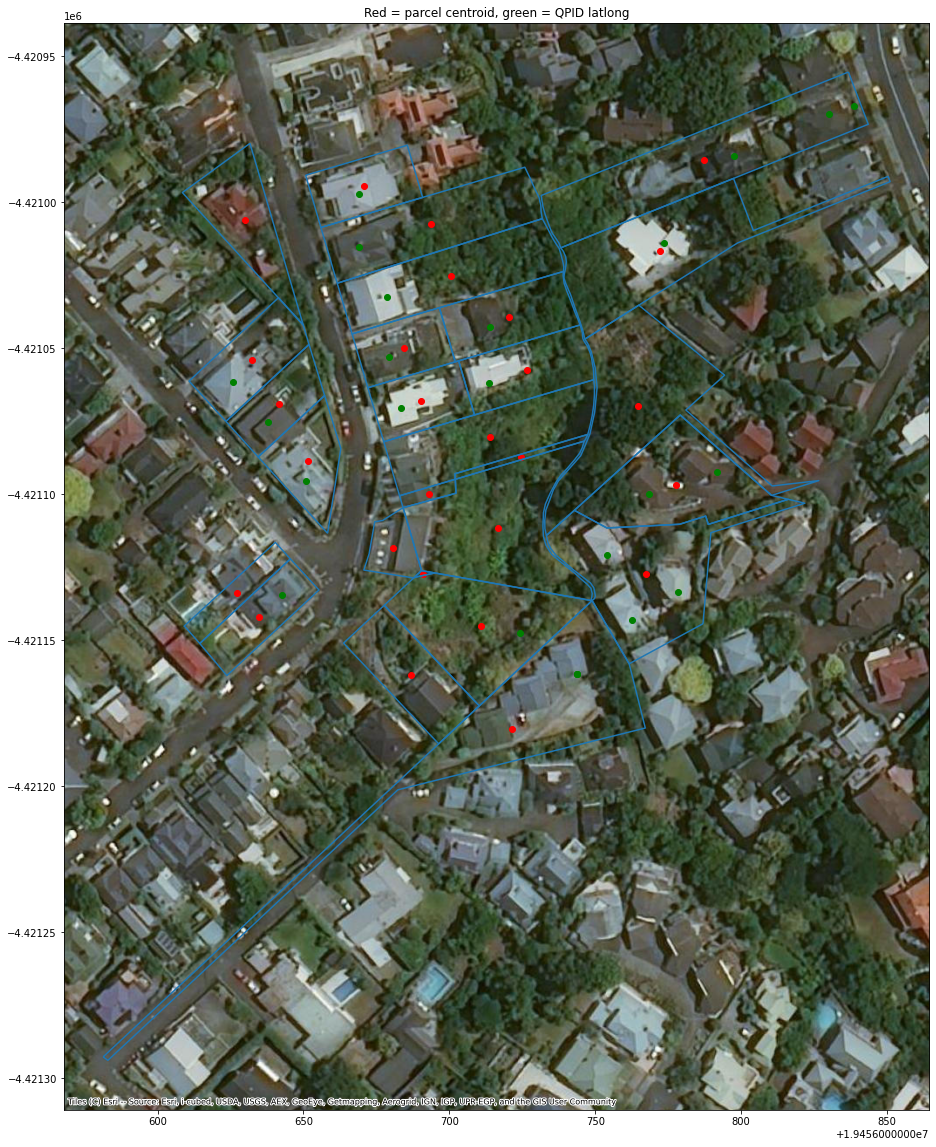

In [ ]:
ax = sample_parcels.boundary.to_crs(epsg=3857).plot()
sample_parcels.centroid.to_crs(epsg=3857).plot(ax=ax, color="red")
df[df.index_right.isin(sample_parcels.index)].to_crs(epsg=3857).plot(ax=ax, color="green")
ctx.add_basemap(ax, url=ctx.providers.Esri.WorldImagery)
plt.title("Red = parcel centroid, green = QPID latlong")